In [39]:
# Helpers - CLIP model loading

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 16),
            #nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def load_and_prepare_models(clip_model_name: str, tokenizer_name: str, aesthetic_model_name: str, device: torch.device):
    import open_clip

    print(f"Loading CLIP model {clip_model_name}...")
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(clip_model_name, device=device,
                                                                           pretrained='openai')

    print(f"Loading tokenizer {tokenizer_name}...")
    tokenizer = open_clip.get_tokenizer(tokenizer_name)

    print(f"Loading aesthetic model {aesthetic_model_name}...")
    s = torch.load(aesthetic_model_name, map_location=device)
    aesthetic_model = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
    aesthetic_model.to(device)
    aesthetic_model.load_state_dict(s)
    aesthetic_model.eval()

    return clip_model, clip_preprocess, tokenizer, aesthetic_model

# Helpers - File loading

def get_image_filenames(path: str):
    import os
    import fnmatch, re

    reobj = re.compile(fnmatch.translate("*.jpg"))
    files = set()
    for dir_, _, filenames in os.walk(path):
        for filename in filenames:
            if not reobj.match(filename): continue
            rel_dir = os.path.relpath(dir_, ".")
            rel_file = os.path.join(rel_dir, filename)
            files.add(rel_file)

    images_files = list(files)
    images_files.sort()

    return images_files

# Helpers - Image manipulation

from PIL import Image

def create_image_batch(image: Image, slices=5):
    w, h = image.size
    delta = abs(w - h)

    if delta / slices < 1:
        slices = 1

    if slices > 1:
        offset = delta / (slices - 1)
        if w < h:
            boxes = [(0, i * offset, w, i * offset + w) for i in range(slices)]
        else:
            boxes = [(i * offset, 0, i * offset + h, h) for i in range(slices)]
    else:
        if w < h:
            boxes = [(0, h / 2 - w / 2, w, h / 2 + w / 2)]
        else:
            boxes = [(w / 2 - h / 2, 0, w / 2 + h / 2, h)]

    return [image.crop(box) for box in boxes]

In [40]:
# Setup - Initialize models for use in playgrounds

import torch

torch.manual_seed(1234)
device = torch.device("mps")

clip_model_name = 'ViT-L-14'  # Remote file--will be downloaded
tokenizer_name = 'ViT-B-32-quickgelu'  # Remote file--will be downloaded
aesthetic_model_name = "sac+logos+ava1-l14-linearMSE.pth"  # Local file--must be present

clip_model, clip_preprocess, tokenizer, aesthetic_model = load_and_prepare_models(clip_model_name, tokenizer_name,
                                                                                  aesthetic_model_name, device)

# Helpers - Aesthetics

@torch.no_grad()
def predict_aesthetic_value(image: Image):
    preprocessed = clip_preprocess(image).to(device)
    image_features = clip_model.encode_image(preprocessed.unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    prediction = aesthetic_model(image_features).to(device)
    return prediction

# Helpers - CLIP features

@torch.no_grad()
def extract_image_features(image: Image):
    preprocessed_image = clip_preprocess(image).to(device)
    image_features = clip_model.encode_image(preprocessed_image.unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

@torch.no_grad()
def predict_text_probabilities(image: Image, text: [str]):
    preprocessed_image = clip_preprocess(image).to(device)
    tokenized_text = tokenizer(text).to(device)
    image_features = clip_model.encode_image(preprocessed_image.unsqueeze(0))
    text_features = clip_model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return image_features, text_features, text_probs

Loading CLIP model ViT-L-14...
Loading tokenizer ViT-B-32-quickgelu...
Loading aesthetic model sac+logos+ava1-l14-linearMSE.pth...


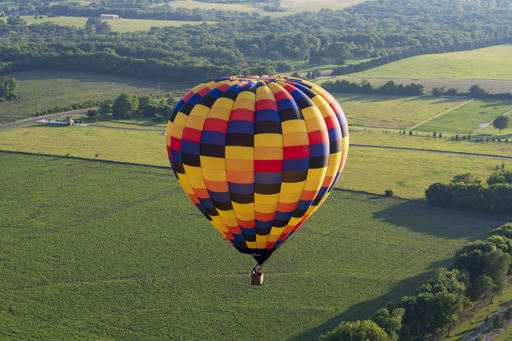

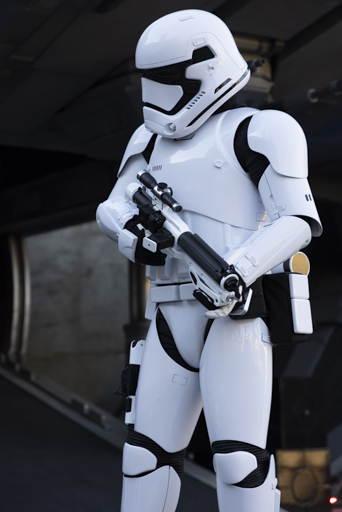

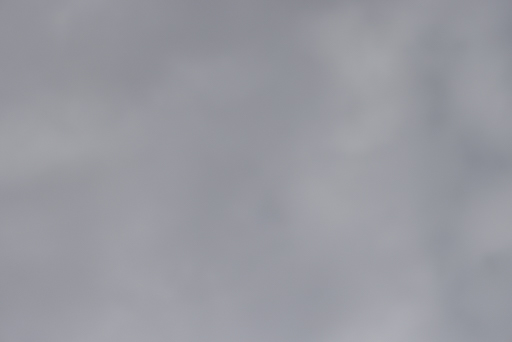

In [41]:
# Setup - Initialize sample images

balloon_image = Image.open("sample_images/balloon.jpg")
storm_trooper_image = Image.open("sample_images/storm_trooper.jpg")
cloud_image = Image.open("sample_images/clouds-out_of_focus.jpg")

display(balloon_image, storm_trooper_image, cloud_image)

In [42]:
# Playground - Aesthetics

@torch.no_grad()
def slice_and_predict_aesthetics(image: Image, slices=5):
    images = create_image_batch(image, slices=slices)
    values = torch.stack([predict_aesthetic_value(i) for i in images])
    return {
        "slices": len(images),
        "std": torch.std(values).item(),
        "min": torch.min(values).item(),
        "max": torch.max(values).item(),
        "mean": torch.mean(values).item(),
    }

def process_directory(path: str, slices=5):
    from tqdm.autonotebook import tqdm

    for image_filename in tqdm(get_image_filenames(path)):
        aggregate = slice_and_predict_aesthetics(Image.open(image_filename), slices)
        aggregate["filename"] = image_filename
        tqdm.write(f"{aggregate}")

# Batch process the sample directory or individual images

# process_directory("sample_images")

print(slice_and_predict_aesthetics(balloon_image, slices=7))
print(slice_and_predict_aesthetics(storm_trooper_image, slices=7))
print(slice_and_predict_aesthetics(cloud_image, slices=7))

{'slices': 7, 'std': 0.059152163565158844, 'min': 5.865179061889648, 'max': 6.024010181427002, 'mean': 5.945931434631348}
{'slices': 7, 'std': 0.08980808407068253, 'min': 5.808446884155273, 'max': 6.074256896972656, 'mean': 5.927739143371582}
{'slices': 7, 'std': 0.03739943727850914, 'min': 3.8377904891967773, 'max': 3.938386917114258, 'mean': 3.8851263523101807}


In [43]:
# Playground - CLIP image features

extract_image_features(storm_trooper_image)

tensor([[ 1.2187e-02,  4.9766e-03,  2.0634e-02, -2.0707e-02, -5.0584e-03,
          1.1941e-02,  6.0326e-03, -6.4675e-03,  1.2585e-02,  7.3772e-03,
         -1.0089e-02, -1.2129e-02, -9.2660e-03,  2.9470e-02,  3.5567e-02,
         -3.8031e-03, -2.4182e-02,  6.2454e-03,  1.2858e-02,  4.3483e-03,
         -2.2092e-03,  4.0961e-03, -4.0019e-02, -3.3425e-02, -1.1982e-01,
          8.4355e-03,  1.2958e-02, -1.6742e-02,  3.2981e-02,  1.8478e-02,
          2.3953e-02, -1.9303e-02, -1.8430e-02,  2.5145e-02,  9.9904e-03,
          1.1939e-03, -4.8206e-03, -5.2020e-03, -3.6115e-02, -1.7771e-02,
          4.3978e-02, -2.7260e-03,  8.6476e-03,  2.3293e-02, -8.3483e-03,
          1.2731e-02, -1.1851e-02, -2.8029e-02, -2.4077e-02,  2.0277e-02,
         -6.0805e-03, -1.0152e-02,  1.6144e-02,  1.3064e-03,  2.8221e-02,
          3.6495e-02, -2.3087e-02, -2.2480e-03, -3.9171e-03, -3.4314e-02,
         -2.5469e-02, -7.4587e-03, -5.8501e-03,  2.0012e-02,  1.2777e-02,
         -2.2269e-02, -1.0894e-02,  2.

In [44]:
# Playground - CLIP text probabilities

predict_text_probabilities(balloon_image, ["hot air balloon", "brown dog"])

(tensor([[ 2.0695e-02, -8.8461e-03, -6.9280e-03, -2.8982e-02, -4.2228e-02,
          -8.9622e-03, -1.6307e-03,  2.8961e-02, -2.3264e-02,  1.7830e-02,
          -1.4936e-02, -1.4941e-03, -4.8545e-04, -4.4372e-03, -2.0308e-02,
           1.2551e-02,  4.8839e-03,  6.4988e-03,  4.1836e-03, -2.2688e-02,
          -1.2450e-02,  3.6109e-02, -2.8709e-02,  8.1792e-03, -5.6236e-02,
           1.0130e-02,  2.3589e-02, -2.2321e-02, -1.0468e-02, -2.8745e-02,
          -3.6692e-02,  3.8793e-02, -7.9190e-03, -1.9860e-03,  1.8066e-03,
           1.8459e-03, -3.1300e-03, -1.0135e-02,  7.3636e-03,  1.0030e-02,
           2.1680e-02, -1.4536e-02,  3.1676e-02,  4.2084e-02, -5.3444e-03,
           1.9471e-02, -1.7470e-02,  5.2708e-03, -3.8145e-03,  2.8788e-03,
           2.4076e-02, -9.6043e-03,  5.8890e-03,  2.5425e-02,  3.5985e-03,
          -8.5156e-04, -3.6833e-02, -2.7405e-02, -2.9685e-02, -2.5358e-02,
           1.0808e-03, -2.4164e-02, -1.0341e-03, -6.2181e-03,  2.2611e-02,
          -2.9332e-02, -2